In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [5]:
# Create a function to plot smoothed metric and loss curves
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [6]:
df = pd.read_pickle("Data/df_final1.pkl")

In [7]:
df_nn_cat = df.copy()

In [8]:
X = df_nn_cat.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                      "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee"]]

y = df_nn_cat["difference"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [11]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))

In [9]:
# Create functions that can take a number of hyperparameters and create neural networks with all combinations
def modeller(X_train, y_train, X_test, y_test, X_val, y_val, num_layers, neurons, activation, optimizer):
    model = Sequential()
    
    model.add(layers.Dense(neurons, input_shape=(11,), activation=activation))
    
    for i in range(num_layers-1):
        model.add(layers.Dense(neurons, activation=activation))
        
    model.add(layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss="mean_squared_error", 
                  metrics=tf.keras.metrics.RootMeanSquaredError())
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    val_loss_score, val_rmse_score = model.evaluate(X_val, y_val, verbose=0)
    
    return val_loss_score, val_rmse_score


In [10]:
def optimizer(num_layers, neurons, activations, optimizers):
    best_rmse = 9999
    
    start = time.time()

    for num in num_layers:
        for neur in neurons:
            for act in activations:
                for opt in optimizers:
                    print(f"Running a model with {num} layers, {neur} neurons, " \
                          f"{act} activation, and {opt} optimizer.")
                    
                    val_loss_score, val_rmse_score = modeller(X_train, y_train, X_test, y_test, X_val, y_val, 
                                                                  num, neur, act, opt)
                    
                    stop = time.time()
                    print(f"It took {np.round(stop-start)} seconds ({(np.round(stop-start))/60} minutes) "\
                          "to run this model.")
                    start = time.time()

                    if val_rmse_score < best_rmse:
                        best_rmse = val_rmse_score
                        best_num_layers = num
                        best_neurons = neur
                        best_activation = act
                        best_optimizer = opt
                        
                        print(f"Best RMSE updated to: {best_rmse}.")
                        
    return best_rmse, best_num_layers, best_neurons, best_activation, best_optimizer


In [11]:
result = optimizer([2, 4, 6, 8], [16, 32, 64, 128], 
                   ["linear", "relu", "sigmoid", "tanh"], ["adam", "adagrad", "adadelta"])

Running a model with 2 layers, 16 neurons, linear activation, and adam optimizer.
It took 66.0 seconds (1.1 minutes) to run this model.
Best RMSE updated to: 1.7874454259872437.
Running a model with 2 layers, 16 neurons, linear activation, and adagrad optimizer.
It took 60.0 seconds (1.0 minutes) to run this model.
Best RMSE updated to: 1.785861849784851.
Running a model with 2 layers, 16 neurons, linear activation, and adadelta optimizer.
It took 62.0 seconds (1.0333333333333334 minutes) to run this model.
Running a model with 2 layers, 16 neurons, relu activation, and adam optimizer.
It took 62.0 seconds (1.0333333333333334 minutes) to run this model.
Best RMSE updated to: 1.7802590131759644.
Running a model with 2 layers, 16 neurons, relu activation, and adagrad optimizer.
It took 59.0 seconds (0.9833333333333333 minutes) to run this model.
Running a model with 2 layers, 16 neurons, relu activation, and adadelta optimizer.
It took 62.0 seconds (1.0333333333333334 minutes) to run thi

It took 72.0 seconds (1.2 minutes) to run this model.
Running a model with 4 layers, 16 neurons, sigmoid activation, and adagrad optimizer.
It took 66.0 seconds (1.1 minutes) to run this model.
Running a model with 4 layers, 16 neurons, sigmoid activation, and adadelta optimizer.
It took 71.0 seconds (1.1833333333333333 minutes) to run this model.
Running a model with 4 layers, 16 neurons, tanh activation, and adam optimizer.
It took 70.0 seconds (1.1666666666666667 minutes) to run this model.
Running a model with 4 layers, 16 neurons, tanh activation, and adagrad optimizer.
It took 65.0 seconds (1.0833333333333333 minutes) to run this model.
Running a model with 4 layers, 16 neurons, tanh activation, and adadelta optimizer.
It took 70.0 seconds (1.1666666666666667 minutes) to run this model.
Running a model with 4 layers, 32 neurons, linear activation, and adam optimizer.
It took 76.0 seconds (1.2666666666666666 minutes) to run this model.
Running a model with 4 layers, 32 neurons, li

It took 77.0 seconds (1.2833333333333334 minutes) to run this model.
Running a model with 6 layers, 32 neurons, relu activation, and adam optimizer.
It took 87.0 seconds (1.45 minutes) to run this model.
Running a model with 6 layers, 32 neurons, relu activation, and adagrad optimizer.
It took 72.0 seconds (1.2 minutes) to run this model.
Running a model with 6 layers, 32 neurons, relu activation, and adadelta optimizer.
It took 78.0 seconds (1.3 minutes) to run this model.
Running a model with 6 layers, 32 neurons, sigmoid activation, and adam optimizer.
It took 88.0 seconds (1.4666666666666666 minutes) to run this model.
Running a model with 6 layers, 32 neurons, sigmoid activation, and adagrad optimizer.
It took 74.0 seconds (1.2333333333333334 minutes) to run this model.
Running a model with 6 layers, 32 neurons, sigmoid activation, and adadelta optimizer.
It took 79.0 seconds (1.3166666666666667 minutes) to run this model.
Running a model with 6 layers, 32 neurons, tanh activation

It took 78.0 seconds (1.3 minutes) to run this model.
Running a model with 8 layers, 32 neurons, tanh activation, and adadelta optimizer.
It took 86.0 seconds (1.4333333333333333 minutes) to run this model.
Running a model with 8 layers, 64 neurons, linear activation, and adam optimizer.
It took 106.0 seconds (1.7666666666666666 minutes) to run this model.
Running a model with 8 layers, 64 neurons, linear activation, and adagrad optimizer.
It took 86.0 seconds (1.4333333333333333 minutes) to run this model.
Running a model with 8 layers, 64 neurons, linear activation, and adadelta optimizer.
It took 92.0 seconds (1.5333333333333334 minutes) to run this model.
Running a model with 8 layers, 64 neurons, relu activation, and adam optimizer.
It took 112.0 seconds (1.8666666666666667 minutes) to run this model.
Running a model with 8 layers, 64 neurons, relu activation, and adagrad optimizer.
It took 85.0 seconds (1.4166666666666667 minutes) to run this model.
Running a model with 8 layers,

In [13]:
print(result)

(1.779585361480713, 2, 128, 'relu', 'adam')


In [12]:
# Create the optimal model and run it for 100 epochs
model = Sequential()
model.add(layers.Dense(128, input_shape=(11,), activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError())
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), use_multiprocessing=True)

Epoch 1/100
13322/13322 [==============================] - 14s 1ms/step - loss: 3.4180 - root_mean_squared_error: 1.8488 - val_loss: 3.1765 - val_root_mean_squared_error: 1.7823
Epoch 2/100
13322/13322 [==============================] - 13s 995us/step - loss: 3.4125 - root_mean_squared_error: 1.8473 - val_loss: 3.1821 - val_root_mean_squared_error: 1.7839
Epoch 3/100
13322/13322 [==============================] - 12s 924us/step - loss: 3.4111 - root_mean_squared_error: 1.8469 - val_loss: 3.1707 - val_root_mean_squared_error: 1.7806
Epoch 4/100
13322/13322 [==============================] - 13s 939us/step - loss: 3.4088 - root_mean_squared_error: 1.8463 - val_loss: 3.1738 - val_root_mean_squared_error: 1.7815
Epoch 5/100
13322/13322 [==============================] - 12s 894us/step - loss: 3.4094 - root_mean_squared_error: 1.8465 - val_loss: 3.1744 - val_root_mean_squared_error: 1.7817
Epoch 6/100
13322/13322 [==============================] - 13s 973us/step - loss: 3.4067 - root_mean_s

Epoch 92/100
13322/13322 [==============================] - 12s 886us/step - loss: 3.3888 - root_mean_squared_error: 1.8409 - val_loss: 3.1681 - val_root_mean_squared_error: 1.7799
Epoch 93/100
13322/13322 [==============================] - 12s 877us/step - loss: 3.3913 - root_mean_squared_error: 1.8415 - val_loss: 3.1648 - val_root_mean_squared_error: 1.7790
Epoch 94/100
13322/13322 [==============================] - 12s 875us/step - loss: 3.3967 - root_mean_squared_error: 1.8430 - val_loss: 3.1651 - val_root_mean_squared_error: 1.7791
Epoch 95/100
13322/13322 [==============================] - 13s 956us/step - loss: 3.3942 - root_mean_squared_error: 1.8423 - val_loss: 3.1676 - val_root_mean_squared_error: 1.7798
Epoch 96/100
13322/13322 [==============================] - 15s 1ms/step - loss: 3.3933 - root_mean_squared_error: 1.8421 - val_loss: 3.1752 - val_root_mean_squared_error: 1.7819
Epoch 97/100
13322/13322 [==============================] - 12s 887us/step - loss: 3.3930 - root_

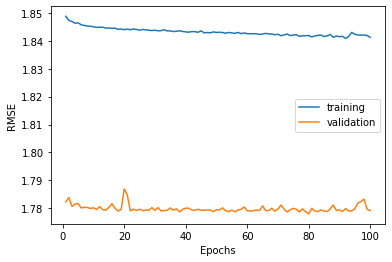

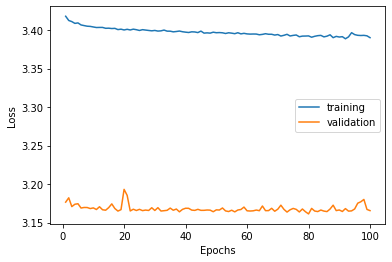

In [15]:
rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

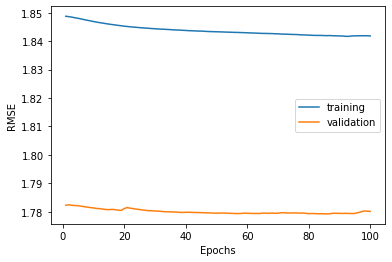

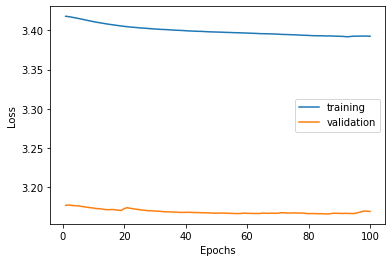

In [16]:
smooth_rmse_history = smooth_curve(rmse_history)
smooth_val_rmse_history = smooth_curve(val_rmse_history)

plt.plot(range(1, len(smooth_rmse_history) + 1), smooth_rmse_history)
plt.plot(range(1, len(smooth_val_rmse_history) + 1), smooth_val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

smooth_loss_history = smooth_curve(loss_history)
smooth_val_loss_history = smooth_curve(val_loss_history)

plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history)
plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [17]:
model.evaluate(X_val, y_val)

2351/2351 [==============================] - 1s 487us/step - loss: 3.1655 - root_mean_squared_error: 1.7792


In [19]:
model.evaluate(X_test, y_test)

1742/1742 [==============================] - 1s 481us/step - loss: 3.3556 - root_mean_squared_error: 1.8318


In [21]:
val_pred = model.predict(X_val).ravel()
test_pred = model.predict(X_test).ravel()

In [23]:
inv_val_pred = scaler.inverse_transform(val_pred.reshape(-1, 1))
inv_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

inv_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_val = mean_squared_error(inv_y_val, inv_val_pred)
mse_test = mean_squared_error(inv_y_test, inv_test_pred)

print("RMSE on validation set:", np.sqrt(mse_val))
print("RMSE on test set:", np.sqrt(mse_test))

RMSE on validation set: 21.35017
RMSE on test set: 21.982056


In [24]:
percentages = []

for idx, val in enumerate(inv_test_pred):
    perc = np.abs(val-inv_y_test[idx])/inv_y_test[idx]
    percentages.append(perc[0])

In [25]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 25.639999389648438
Mean percent error: 1.0399999618530273


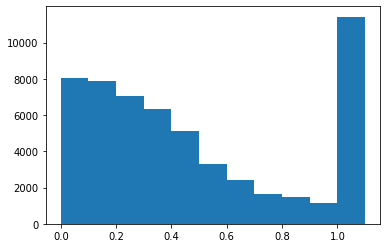

In [26]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [27]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 34400
Percentage of orders with a percent error lower than 0.5: 0.62


In [28]:
differences = []

for idx, val in enumerate(inv_y_test):
    differences.append(np.abs(val[0]-inv_test_pred[idx][0]))

In [29]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [30]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.12
Percentage of orders predicted correctly within 3 days: 0.28
Percentage of orders predicted correctly within 5 days: 0.43
Percentage of orders predicted correctly within 7 days: 0.57
